# <span style='color:darkred'> 4 Trajectory Analysis </span>

***

**<span style='color:darkred'> Important Note </span>**

Before proceeding to the rest of the analysis, it is a good time to define a path that points to the location of the MD simulation data, which we will analyze here.

If you successfully ran the MD simulation, the correct path should be:

In [4]:
# Execute the cell to define the path to your simulation files
path="OxCompBio-Datafiles/run"

If however, you need/want to use the data from the simulation that has been already performed, uncomment the command below to instead define the path that points to the prerun simulation.

In [2]:
# Uncomment the line below and execute the cell to define the path to the prerun simulation files
#path="OxCompBio-Datafiles/prerun/run"

## <span style='color:darkred'> 4.1 Visualize the simulation </span>

The simplest and easiest type of analysis you should always do is to look at it with your eyes! Your eyes will tell you if something strange is happening immediately. A numerical analysis may not.

### <span style='color:darkred'>  4.1.1 VMD </span>

*Note: Again, this step is optional. If you don't have VMD, go to section 4.1.2 below to visualize the trajectory with NGLView instead.*

Let us look at the simulations on VMD.

Open your vmd, by typing on your terminal:

`% vmd`

When it has finished placing all the windows on the screen. Click on `File` in the VMD main menu window and select `New Molecule`. The Molecule File Browser window should appear. Click on `Browse...` then select the `OxCompBio-Datafiles` and then the `run` directory and finally select `em.gro` (i.e. the file you made that has protein system energy minimized). Click `OK` and then click `Load`. It should load up the starting coordinates into the main window. Then click `Browse...` in the Molecule File Browser window. Select again the `OxCompBio-Datafiles`, then the `run` directory and then `md.xtc`. Select `OK` and then hit `Load`. The trajectory should start loading into the main VMD window. 

Although things will be moving, you can see that it is quite difficult to visualize the individual components. That is one of the problems with simulating such large and complicated systems. VMD makes it quite easy to look at individual components of a system. For example, let us consider the protein only. On the VMD Main menu, left-click on Graphics and select `Representations`. A new menu will appear (`Graphical Representations`). In the box entitled `Selected Atoms` type protein and hit enter. Only those atoms that form part of the protein are now selected. Various other selections and drawing methods will help to visualize different aspects of the simulation. 

<span style='color:Blue'> **Questions**  </span> 

* How would you say the protein behaves? 


* Is it doing anything unexpected? What would you consider unexpected behaviour?


* Can you add representations for the ASP and the ARG residues only? Can you observe if they form any inter-subunit interactions? We will quantify those later on.

### <span style='color:darkred'> 4.1.2 NGLView </span>


You have already tested NGLView at the Python tutorial (Notebook `12_ProteinAnalysis`) and at the beginning of this tutorial. This time however, you can visualize the trajectory you generated after carrying out the MD simulation.

You should also be familiar now with the MDAnalysis Python library that we will use to analyze the MD trajectory. We will also use it below, to create a Universe and load it on NGLView.

In [5]:
# Import MDAnalysis and NGLView
import MDAnalysis
import nglview

# Load the protein structure and the trajectory as a universe named protein
protein=MDAnalysis.Universe(f"{path}/em.gro", f"{path}/md_fit.xtc")
protein_view = nglview.show_mdanalysis(protein)
protein_view.gui_style = 'ngl'

#Color the protein based on its secondary structure
protein_view.update_cartoon(color='sstruc')
protein_view

ThemeManager()

NGLWidget(gui_style='ngl', max_frame=100)

<span style='color:Blue'> **Questions**  </span> 

* How would you say the protein behaves? 


* Is it doing anything unexpected? What would you consider unexpected behaviour?


* Can you add representations for the ASP and the ARG residues only? Can you observe if they form any inter-subunit interactions? We will quantify those later on.

Now that we are sure the simulation is not doing anything ridiculous, we can start to ask questions about the simulation. The first thing to establish is whether the simulation has equilibrated to some state. So what are some measures of the system
being equilibrated? And what can we use to test the reliability of the simulation?

## <span style='color:darkred'> 4.2 System Equilibration </span> 

### <span style='color:darkred'> 4.2.1 Temperature fluctuation </span>

The system temperature as a function of time was calculated in the previous section, with the built-in GROMACS tool `gmx energy`, but we still have not looked at it. It is now time to plot the temperature *vs* time and assess the results.

<span style='color:Blue'> **Questions**  </span> 

* Does the temperature fluctuate around an equilibrium  value?


* Does this value correspond to the temperature that we predefined in the `md.mdp` input file?

Import numpy and pyplot from matplotlib, required to read and plot the data, respectively.

In [6]:
# We declare matplotlib inline to make sure it plots properly
%matplotlib inline
# We need to import numpy 
import numpy as np
# We need pyplot from matplotlib to generate our plots
from matplotlib import pyplot

Now, using numpy, we can read the data from the `1hsg_temperature.xvg` file; the first column is the time (in ps) and the secong is the system temperature (in K).

In [7]:
# Read the file that contains the system temperature for each frame
time=np.loadtxt(f"{path}/1hsg_temperature.xvg", comments=['#','@'])[:, 0]
temperature=np.loadtxt(f"{path}/1hsg_temperature.xvg", comments=['#','@'])[:, 1] 

You can use numpy again to compute the average temperature and its standard deviation.

In [8]:
# Calculate and print the mean temperature and the standard deviation
# Keep only two decimal points
mean_temperature=round(np.mean(temperature), 2)
std_temperature=round(np.std(temperature), 2)
print(f"The mean temperature is {mean_temperature} ± {std_temperature} K")

The mean temperature is 300.29 ± 1.67 K


Finally, you can plot the temperature *vs* simulation time.

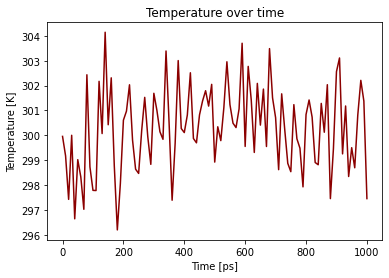

In [9]:
# Plot the temperature
pyplot.plot(time, temperature, color='darkred')
pyplot.title("Temperature over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Temperature [K]")
pyplot.show()

### <span style='color:darkred'> 4.2.2 Energy of the system </span> 

Another set of properties that is quite useful to examine is the various energetic contributions to the energy. The total
energy should be constant. but the various contributions can change and this can sometimes indicate something
interesting or strange happening in your simulation. Let us look at some energetic properties of the simulation.

We have already exctracted the Lennard-Jones energy, the Coulomb energy and the potential energy using again the GROMACS built-in tool `gmx energy`. The data of these three energetic components are saved in the same file called `1hsg_energies.xvg`; the first column contains the time (in ps) and the columns that follow contain the energies (in kJ/mol), in the same order as they were generated.

We can now read the data from the `1hsg_energies.xvg` file using numpy.

In [10]:
# Read the file that contains the various energetic components for each frame
time=np.loadtxt(f"{path}/1hsg_energies.xvg", comments=['#','@'])[:, 0]
lennard_jones=np.loadtxt(f"{path}/1hsg_energies.xvg", comments=['#','@'])[:, 1]
coulomb=np.loadtxt(f"{path}/1hsg_energies.xvg", comments=['#','@'])[:, 2]
potential=np.loadtxt(f"{path}/1hsg_energies.xvg", comments=['#','@'])[:, 3]

And now that we read the data file, we can plot the energetic components *vs* simulation time in separate plots using matplotlib.

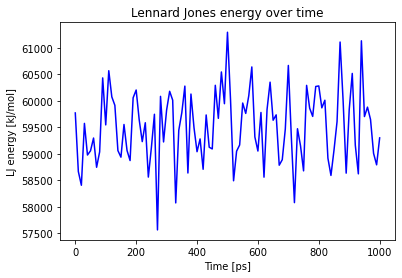

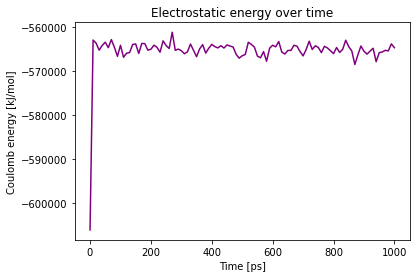

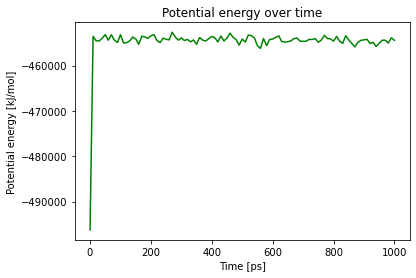

In [11]:
# Plot the Lennard-Jones energy
pyplot.plot(time, lennard_jones, color='blue')
pyplot.title("Lennard Jones energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("LJ energy [kJ/mol]")
pyplot.show()

# Plot the electrostatic energy
pyplot.plot(time, coulomb, color='purple')
pyplot.title("Electrostatic energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Coulomb energy [kJ/mol]")
pyplot.show()

# Plot the potential energy
pyplot.plot(time, potential, color='green')
pyplot.title("Potential energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Potential energy [kJ/mol]")
pyplot.show()

<span style='color:Blue'> **Questions**  </span> 

* Can you plot the Coulomb energy and the potential energy, following the same steps as above? 


* Is the total energy stable in this simulation? 


* What is the dominant contribution to the potential energy?

## <span style='color:darkred'> 4.3 Analysis of Protein </span>

*Hint:* Ideally, you should visualize the trajectory with either VMD or NGLView and combine the information you extract from the plots with what you observe visually. That applies to all the structural analysis that you perform. So feel free at any point to go back to VMD or NGLView to verify the results you get from the analysis below.

### <span style='color:darkred'> 4.3.1 Root mean square deviation (RMSD) of 1HSG </span>

The RMSD gives us an idea of how 'stable' our protein is when compared to our starting, static, structure. The lower the RMSD is, the more stable we can say our protein is. 

The RMSD as a function of time, $\rho (t)$, can be defined by the following equation:

\begin{equation}
\\
\rho (t) = \sqrt{\frac{1}{N}\sum^N_{i=1}w_i\big(\mathbf{x}_i(t) - \mathbf{x}^{\text{ref}}_i\big)^2}
\end{equation}

Luckily MDAnalysis has its own built-in function to calculate this and we can import it.



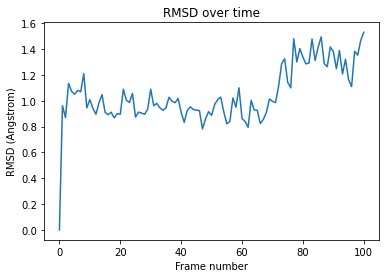

In [12]:
# Import built-in MDAnalysis tools for alignment and RMSD.
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSD as rmsd

# Define the simulation universe and the reference structure (protein structure at first frame)
protein = MDAnalysis.Universe(f"{path}/md.gro", f"{path}/md_fit.xtc")
protein_ref = MDAnalysis.Universe(f"{path}/em.gro", f"{path}/md_fit.xtc")
protein_ref.trajectory[0]

# Call the MDAnalysis align function to align the MD simulation universe to the reference (first frame) universe
align_strucs = align.AlignTraj(protein, protein_ref, select="backbone", weights="mass", in_memory=True, verbose=True)

R = align_strucs.run()
rmsd_data = R.rmsd

# Plot the RMSD
pyplot.plot(rmsd_data)
pyplot.title("RMSD over time")
pyplot.xlabel("Frame number")
pyplot.ylabel("RMSD (Angstrom)")
pyplot.show()


<span style='color:Blue'> **Questions**  </span> 

* What does this tell you about the stability of the protein? Is it in a state of equilibrium and if so why and at what time?


* Can you think of a situation where this approach might not be a very good indication of stability?

### <span style='color:darkred'> 4.3.2 Root mean square fluctuation (RMSF) of 1HSG </span>

A similar property that is particularly useful is the root mean square fluctuation (RMSF), which shows how each residue flucuates over its average position.

The RMSF for an atom, $\rho_i$, is given by:

\begin{equation}
\rho_i = \sqrt{\sum^N_{i=1} \big\langle(\mathbf{x}_i - \langle \mathbf{x}_i \rangle )^2 \big\rangle }
\end{equation}

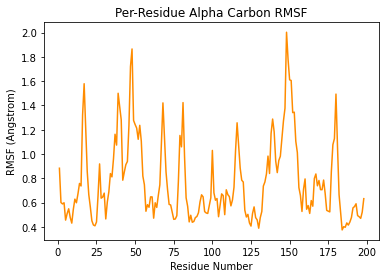

In [14]:
from MDAnalysis.analysis.rms import RMSF as rmsf

# Define again the simulation universe, using however the renumbered .gro file that you had generated earlier
protein = MDAnalysis.Universe(f"{path}/em.gro", f"{path}/md_fit.xtc")

# Reset the trajectory to the first frame
protein.trajectory[0]

# We will need to select the alpha Carbons only
calphas = protein.select_atoms("name CA")

# Compute the RMSF of alpha carbons. Omit the first 20 frames,
# assuming that the system needs this amount of time (200 ps) to equilibrate
rmsf_calc = rmsf(calphas, verbose=True).run(start=20)

# Plot the RMSF
pyplot.plot(calphas.resindices+1, rmsf_calc.rmsf, color='darkorange' )
pyplot.title("Per-Residue Alpha Carbon RMSF")
pyplot.xlabel("Residue Number")
pyplot.ylabel("RMSF (Angstrom)")
pyplot.show()

<span style='color:Blue'> **Questions**  </span> 

* Can you identify structural regions alone from this plot and does that fit in with the structure?


* Residues 43-58 form part of the flexible flap that covers the binding site. How does this region behave in the simulation? Remember that you have a homodimer, so chain A contains residues 1-99 and chain B contains residues 100 to 198.

### <span style='color:darkred'> 4.3.3 Hydrogen Bond Formation </span>

We can also use the simulation to monitor the formation of any hydrogen bonds that may be of interest.

In the case of HIV-1 protease, the hydrogen bonds (HB) that are formed between the ARG8', the ASP29 and the ARG87 amino acids at the interface of the two subunits act in stabilising the dimer.

We can analyse the trajectory and monitor the stability of these interactions *vs* simulation time.

/home/mjkikaz2/anaconda3/envs/OxPython/lib/python3.7/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


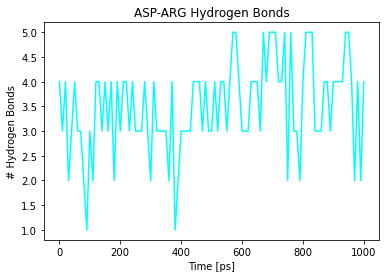

The average number of ASP-ARG HBs is 3.5 ± 0.92


In [16]:
# Import the MDAnalysis built-in tool for HB Analysis
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

# Define the protein universe
# Note that when using this tool, it is recommended to include the .tpr file instead of the .gro file,
# because it contains bond information, required for the identification of donors and acceptors.
protein = MDAnalysis.Universe(f"{path}/md.tpr", f"{path}/md.xtc")

# Define the atom selections for the HB calculation.
# In this case, the ARG hydrogens and the ASP oxygens, which act as the HB acceptors are specifically defined.
hbonds = HBA(universe=protein, hydrogens_sel='resname ARG and name HH21 HH22', acceptors_sel='resname ASP and name OD1 OD2')

# Perform the HB calculation
hbonds.run()
    
# Plot the total number of ASP-ARG HBs vs time
hbonds_time=hbonds.times
hbonds_data=hbonds.count_by_time()

pyplot.plot(hbonds_time, hbonds_data, color='cyan')
pyplot.title("ASP-ARG Hydrogen Bonds")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("# Hydrogen Bonds")
pyplot.show()

# Compute and print the average number of HBs and the standard deviation
aver_hbonds=round(np.mean(hbonds_data), 2)
std_hbonds=round(np.std(hbonds_data), 2)
print(f"The average number of ASP-ARG HBs is {aver_hbonds} ± {std_hbonds}")

<span style='color:Blue'> **Questions**  </span> 

* How much variation is there in the number of hydrogen bonds?


* Do any break and not reform? 


* Using VMD, can you observe the HB formation and breakage throughout the simulation?

***

This concludes the analysis section, but the aim was only to give you an idea of the numerous information that we can gain when analysing an MD trajectory. Feel free to ask and attempt to answer your own questions, utilising the tools that you were introduced to during the tutorial.

## <span style='color:darkred'> 4.4 Further Reading </span>


The texts recommended here are the same as those mentioned in the lecture:
* "Molecular Modelling. Principles and Applications". Andrew Leach. Publisher: Prentice Hall. ISBN: 0582382106. This book has rapidly become the defacto introductory text for all aspects of simulation.
* "Computer simulation of liquids". Allen, Michael P., and Dominic J. Tildesley. Oxford university press, 2017.
* "Molecular Dynamics Simulation: Elementary Methods". J.M. Haile. Publisher: Wiley. ISBN: 047118439X. This text provides a more focus but slightly more old-fashioned view of simulation. It has some nice simple examples of how to code (in fortran) some of the algorithms though.


## <span style='color:darkred'> End of Tutorial </span>

Congratulations, you have finished the MD tutorial. Hopefully, by you are familiar with the molecular dynamics method, the GROMACS software that we have used to perform the simulation, and you have an idea of the type of information that we can extract from an MD run and how we can visualize, compute and plot the data of interest.